## Extending the likelihood and not only using the maximum.

**Goal:** Show that bayesian linear regression is not magic.

**Usage:** 

**Dataset:** Artificial Data

**Content:**

In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow-gpu==2.0.0
        !pip install tensorflow-probability==0.8.0
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0  running in colab?:  False


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions
print("TFB Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFB Version 0.8.0
TF  Version 2.0.0


In [3]:
plt.style.use('default') # macht den hintergrund weg 
plt.rcParams.update({'font.size': 15}) #Macht grosse axen

In [4]:
xmin = -5;xmax = +5;ymin=-40;ymax=40;
nbins_c=30; sigma=3

In [5]:
save = True
np.random.seed(2)
num = 4
#x = np.random.normal(0,1,(num,1)) 
x = np.linspace(-2,2,num=num).reshape((num,1))
y = 2 * x[:,0] - 1 + 1.*np.random.normal(0,sigma,num) 
if save:
        d = np.transpose(np.vstack((x[:,0],y)))
        np.savetxt('nb_ch07_lr_artifical{}.csv'.format(num), d, delimiter=',', header='x,y',comments="",fmt='%.4e'); 
        
from sklearn import linear_model
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(x,y)
# The coefficients
a_ml = regr.coef_
b_ml = regr.intercept_
print('Coefficients: \n', a_ml)
print('Coefficients: \n', b_ml)

Coefficients: 
 [2.92051026]
Coefficients: 
 -1.726712471421449


### Creation of the data set

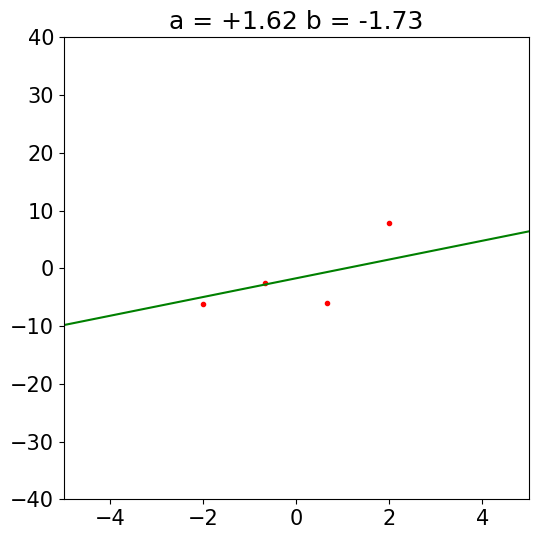

In [6]:
plt.figure(figsize=(6,6))
#a = a_ml[0];b = b_ml
a = a_ml[0]/1.8;b = b_ml
plt.scatter(x,y, marker='.', color='r')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.plot([xmin, xmax], [a*xmin+b, a*xmax+b], color='g', alpha = 1)
plt.title('a = {:+.2f} b = {:+.2f}'.format(a,b))  
plt.savefig('ch06_lr2.pdf')

Calculation of the predictive distribution $p(y|x,a,b)$ for a bunch of values x, and y given a fixed set of parameters.

In [7]:
def pre_distribution(a,b):
    """
        Return the predictive distribution p(y|(a,b)) for a, b
    """
    canvas0 = np.zeros((nbins_c, nbins_c), dtype=np.float32) #The complete img
    xi = np.zeros((nbins_c, nbins_c), dtype=np.float32)
    yi = np.zeros((nbins_c, nbins_c), dtype=np.float32)
    for j,x_ in enumerate(np.linspace(xmin, xmax, nbins_c)):
        py = tfd.Normal(loc=a*x_+b,scale=sigma)
        for i,y_ in enumerate(np.linspace(ymin, ymax, nbins_c)):
            xi[i,j] = x_
            yi[i,j] = y_
            canvas0[i,j] = py.prob(y_)
    # This part is a bit tricky. The sum over y for a fixed a should be 1. 
    # However, due to finite bin width this is not the case.
    # We renormalize
    return canvas0/ np.sum(canvas0,axis=0), xi, yi

<Figure size 600x600 with 0 Axes>

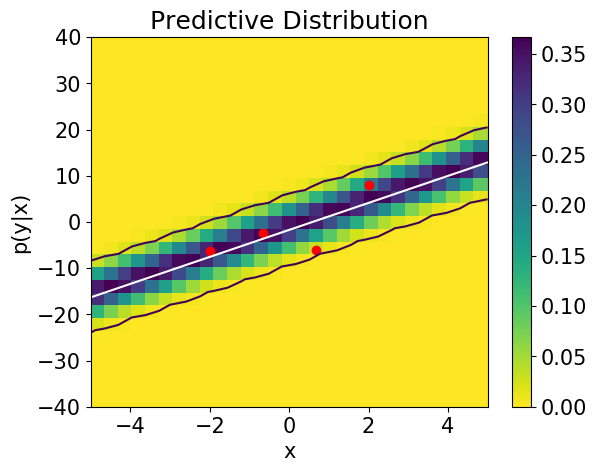

In [8]:
import scipy
pxy_ml,xi,yi = pre_distribution(a_ml, b_ml)

fig = plt.figure(figsize=(6,6))
fig, ax0 = plt.subplots(nrows=1)
cmap = plt.get_cmap('viridis_r',)
im = plt.pcolormesh(xi, yi, pxy_ml, cmap=cmap)
plt.contour(xi, yi, pxy_ml,[scipy.stats.norm(0, sigma).pdf(2*sigma)])
fig.colorbar(im, ax=ax0)
plt.scatter(x,y, marker='o',c='r')
plt.plot([xmin, xmax], [a_ml*xmin+b_ml, a_ml*xmax+b_ml], color='w', alpha = 1)
plt.xlabel('x')
plt.ylabel('p(y|x)')
plt.title('Predictive Distribution')
plt.savefig('ch06_lr4.pdf')

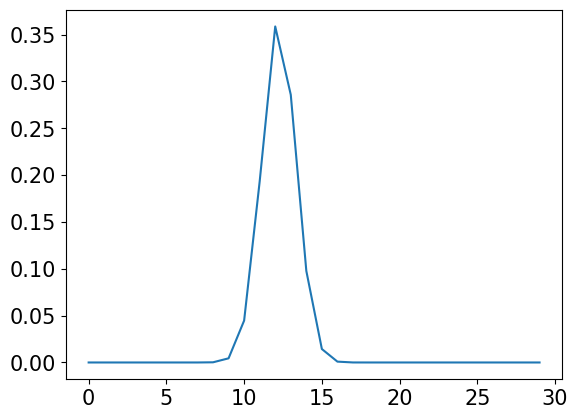

In [9]:
plt.plot(pxy_ml[:,10]) #A slice through the distributions looks quite Gaussian

### Combining serveral predictive distributions

As discussed in the main text. We average many predictive distributions. 

$$
    p(y|x,(a,b)) = Norm(y=ax+b,\sigma=3)
$$

given parameters $(a,b)$ and weight them according to their normalized likelihood $p(a,b)$. So that we get the final predictivedistributions as:

$$
    p(y|x) = \sum_a \sum_b p(a,b) \cdot p(y|x,(a,b))
$$

We evaluate the sum at `nbins` different values for $a$ and also for $b$

We start to calculate the unnormalized likelihood as:

$$
    lik(a,b) = \prod_i^N N(y_i;a*x_i + b,\sigma = 3) 
$$

In [10]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
ytensor = y.reshape([len(y),1]) #A

@tf.function
def unnormalized_likehihood(w):#B
    y_prob = tfd.Independent( #C
        tfd.Normal(loc=x*w[0]+w[1], scale=sigma)
    )
    return tf.reduce_prod(y_prob.prob(ytensor))

#A y is now a 2-dimensional tensor
#B w holds the two random variables a=w[0] and b=w[1] in the Tensor w
#C Definition of the likelihood (independent Gaussian with fixed sigma)
#D Calculation of the log-posterior as defined in eq.log_post

In [11]:
from tqdm import tqdm
#TODO Elvis do you magic
nbins = 30
bmin=-10;bmax=8
amin=-3;amax=8
ai, bi = np.mgrid[amin:amax:nbins*1j, bmin:bmax:nbins*1j] #wtf is j?
ws = np.vstack([ai.flatten(), bi.flatten()])
unpost = np.zeros((nbins*nbins))
for i in tqdm(range((nbins*nbins))):
    w_tf = tf.Variable([[ws[0,i]],[ws[1,i]]],dtype=tf.float32)
    unpost[i] = unnormalized_likehihood(w_tf)
unpost = unpost.reshape(ai.shape)
norm_like = unpost / np.sum(unpost) #<-- We normalize

100%|██████████| 900/900 [00:01<00:00, 580.61it/s]


<Figure size 600x600 with 0 Axes>

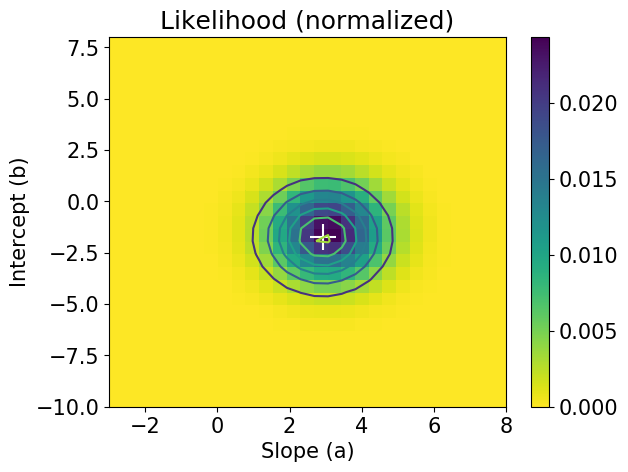

In [12]:
plt.figure(figsize=(6,6))
fig, ax0 = plt.subplots(nrows=1)
cmap = plt.get_cmap('viridis_r')
im = plt.pcolormesh(ai, bi, norm_like, shading='none',cmap=cmap)
fig.colorbar(im, ax=ax0)
plt.contour(ai, bi, norm_like)
plt.scatter(a_ml, b_ml, color='w', marker='+',s=333)
plt.xlabel('Slope (a)')
plt.ylabel('Intercept (b)')
plt.title('Likelihood (normalized)')
plt.savefig('ch06_lrlik.pdf')

In [13]:
def toBin(a, amin, amax):
    a = np.clip(a, amin, amax)
    return int(0.99999*(a - amin)/(amax-amin) * nbins)

def getProb(a,b):
    return norm_like[toBin(a,amin,amax),toBin(b,bmin,bmax)]

In [14]:
getProb(a_ml,b_ml),getProb(a_ml[0] / 1.8, b_ml * 1)

(0.02433014951708463, 0.00975107263868428)

Evaluation of 
$$
    p(y|x,D) = \sum_a \sum_b p(y|x,(a,b))p((a,b)|D)
$$

In [15]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
pyx = np.zeros((nbins_c, nbins_c), dtype=np.float32) #A 
for a in tqdm(np.linspace(amin, amax, nbins)): #B
    for b in np.linspace(bmin, bmax, nbins):
        p = getProb(a,b) #C
        pyx += pre_distribution(a,b)[0] * getProb(a,b) 

#A Start with a blank canvas
#B Loop over "all" parameters a 
#C Get the probability for the parameters a and b, given the data

100%|██████████| 30/30 [03:11<00:00,  6.37s/it]


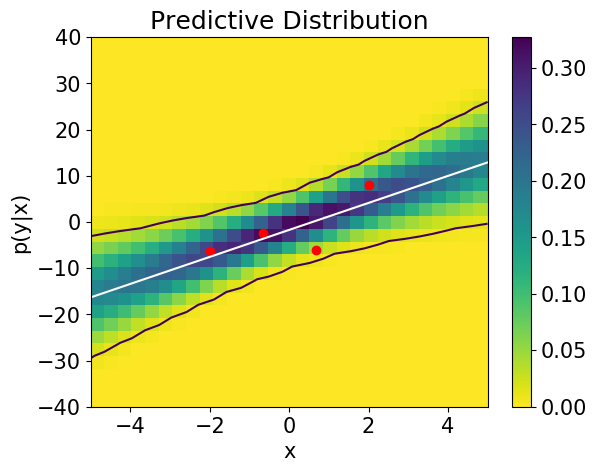

In [17]:
#plt.figure(figsize=(6,6))
fig, ax0 = plt.subplots(nrows=1)
cmap = plt.get_cmap('viridis_r',)
im = plt.pcolormesh(xi, yi, pyx, cmap=cmap)
plt.contour(xi, yi, pyx,[scipy.stats.norm(0, sigma).pdf(2*sigma)])
fig.colorbar(im, ax=ax0)
plt.scatter(x,y, marker='o',c='r')
plt.plot([xmin, xmax], [a_ml*xmin+b_ml, a_ml*xmax+b_ml], color='w', alpha = 1)
plt.xlabel('x')
plt.ylabel('p(y|x)')
plt.title('Predictive Distribution')
plt.savefig('ch06_f_mar.pdf')

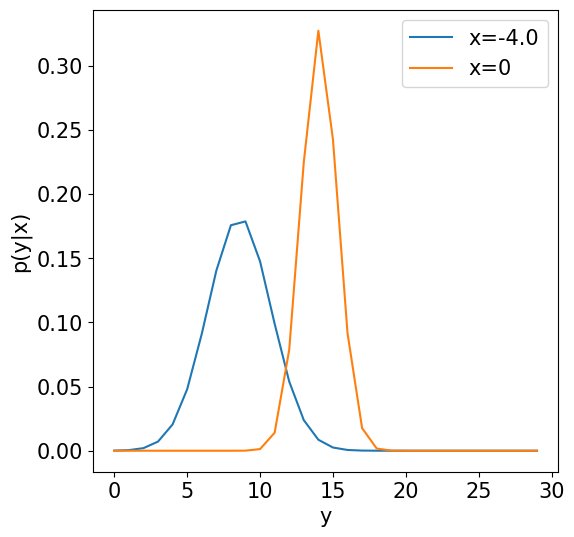

In [18]:
fig = plt.figure(figsize=(6,6))
plt.plot(pyx[:,(0,int(nbins/2))]) 
plt.xlabel('y')
plt.ylabel('p(y|x)')

#TODO Elvis, can to do this?
#Hack Attack:
# We have our labels in pixels from (0 to nbins). They correpond to numbers from
# to ranges from ymin to ymax.
locs, labels = plt.xticks()
plt.legend(['x=-4.0','x=0'])
plt.savefig('ch07_slices.pdf')

<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  

Go back to the main text. The analytical solution below will be discussed in the last part of chapter 7.

# Analytical Solution 

For the special case that $\sigma$ is known there exists an analytic solution. For the analytical solution is is further assumed that the prios for a and b are both normally descributed (no correlation) with same spread of the prior distribution $\sigma_0$.

$$
    a \sim N(0,\sigma_0)
$$

$$
    b \sim N(0,\sigma_0)
$$

Without going into details, the analytical solution can be obtained using the following code. If you are interested the analytical details, they are derived in [Bishop Pattern Recognition and Machine Learning.](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf). There is also a blog post describing descriping the solution http://krasserm.github.io/2019/02/23/bayesian-linear-regression/.

In [19]:
def make_design_matrix(x):
    return np.hstack((np.ones((len(x),1)), x))

def posterior(x, y, one_over_var0, var):
    """
        x vector with training x data
        y vector with training y values
        one_over_var0 1/𝜎0^2 the variances of the prior distribution
        var is the assumed to be known variance of data
        @returns mean vector mu and covariance Matrix Sig 
    """
    X = make_design_matrix(x)
    Sig_inv = one_over_var0 * np.eye(X.shape[1]) + X.T.dot(X) / var
    Sig = np.linalg.inv(Sig_inv)
    mu = Sig.dot(X.T).dot(y) / var
    return mu, Sig

def posterior_predictive(x_test, mu, Sig, var):
    """
        x_test the positions, where the posterior is to be evaluated
        mu the mean values of the weight-posterior
        Sig the covariance matrix 
        var is the assumed to be known variance of data 
        Computes mean and variances of the posterior predictive distribution of y
    """
    X_test = make_design_matrix(x_test)
    y = X_test.dot(mu)
    # Only compute variances (diagonal elements of covariance matrix)
    y_var = var + np.sum(X_test.dot(Sig) * X_test, axis=1)  
    return y, y_var

## Comparison with the brute force solution

Let's first compare the posterior of the weights with the brute force solution. In this case we had a flat prior, which we can model by setting  `one_over_var0`=0

In [20]:
m, Sigma = posterior(x, y, 0.0, sigma**2)

In [21]:
print('Analytical Solution:\n mean (b,a):',m, '\n sigma:\n',Sigma)   
b_ml,a_ml

Analytical Solution:
 mean (b,a): [-1.72671247  2.92051026] 
 sigma:
 [[2.25000000e+00 1.12410081e-16]
 [1.12410081e-16 1.01250000e+00]]


(-1.726712471421449, array([2.92051026]))

#### Comparison with the brute force solution

To compare the brute force solution with the analytical. We calculate a slice of the brute-force unnormalized likelihood solution $l$ in $a$ at 250 support points `ass` with fixed $b=0$ (marginal likelihood). 

For normlization, we use

$$
  \int c \cdot l(a) da \approx \sum_i c \cdot l(a_i) \Delta = 1
$$

With $\Delta$ is the range of a divided by the number of support point.  

In [22]:
bb  = 0
aas = np.linspace(-2,8,250)
l = np.linspace(-2,8,250)
for i,a in enumerate(aas):
    l[i] = unnormalized_likehihood(tf.Variable([a,bb],dtype=tf.float32))

## Normalizing the likelihood
delta = 10./250.
c = 1 / np.sum(l*delta)
p = c*l # The normalized probability density evaluated at the support points 

p is now the density $l$ at the positions $a_i$. Hence,
$$
 1 = \sum p(a_i) \Delta 
$$

$$
 \sum a_i p(a_i) \Delta = mean 
$$


$$
 \sum (a_i - mean)^2 p(a_i) \Delta = var 
$$


In [23]:
np.sum(p * delta) #1 
mean = np.sum(aas * p * delta) 
print(mean)
var = np.sum((aas - mean)**2 * p * delta) 
print('var ', var, '  std ', np.sqrt(var))

2.9205115022755774
var  1.0124830177270003   std  1.0062221512802232


In [24]:
import pandas as pd
pd.DataFrame([[mean,m[1]],[var,Sigma[1,1]]],index=['mean(a)','var(a)'], columns=['Hacker','Analytical'])

,Hacker,Analytical
mean(a),2.920512,2.92051
var(a),1.012483,1.01250


Text(0.5, 1.0, 'Posterior for the slope (a)')

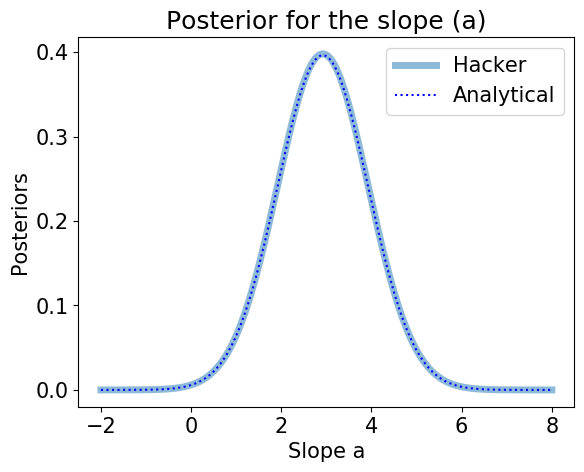

In [25]:
pana = np.linspace(-2,8,250)
i = 0
for i,a in enumerate(aas):
    oben = (a-m[1])**2
    unten = 2*Sigma[1,1]
    pana[i] = np.exp(-oben/unten) / np.sqrt(2*np.pi*Sigma[1,1])
    
plt.plot(aas, p, alpha=0.5,linewidth=5)
plt.plot(aas, pana,linestyle='dotted',c='b')
plt.xlabel('Slope a')
plt.ylabel('Posteriors')
plt.legend(['Hacker ', 'Analytical'])
plt.title('Posterior for the slope (a)')

### Comparison of the posteriori predictive distribution

Besides the posterior of the weights, we can also calculate the posterior predictive distribution. We evaluate the posteriori predictive distribution at many values between the xmin and the xmax, where we also evaluated before for the hackers way.

####  Some slices

[-1.72671247]


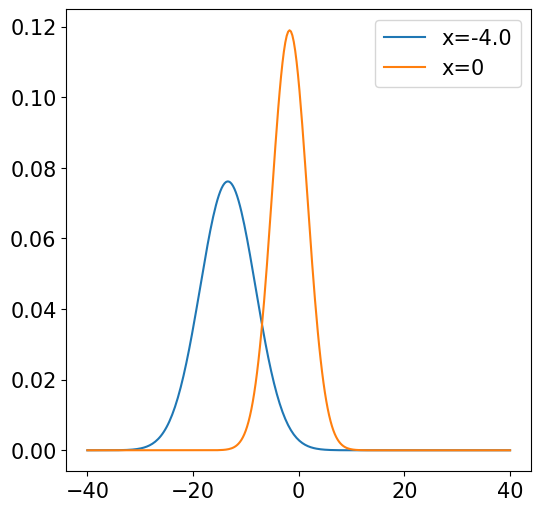

In [26]:
fig = plt.figure(figsize=(6,6))
ys = np.linspace(-40,40,300)

# The point at 4
y_mu, yt_var = posterior_predictive([[-4]], m, Sigma, sigma**2)
pys = scipy.stats.norm(loc=y_mu, scale=np.sqrt(yt_var)).pdf(ys) 
plt.plot(ys, pys)

# The point at 0
y_mu, yt_var = posterior_predictive([[0]], m, Sigma, sigma**2)
pys = scipy.stats.norm(loc=y_mu, scale=np.sqrt(yt_var)).pdf(ys) 
plt.plot(ys, pys)
print(y_mu)
plt.legend(['x=-4.0','x=0'])
plt.savefig('ch07_slices_ana.pdf')

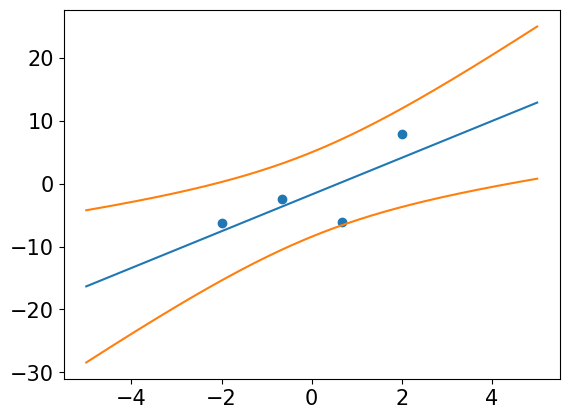

In [27]:
xs = np.linspace(xmin,xmax,250).reshape((250,1))
y_mu, yt_var = posterior_predictive(xs, m, Sigma, sigma**2)
y_mu[0], yt_var[0] 
ax = plt.gca()
color = next(ax._get_lines.prop_cycler)['color']
plt.plot(xs, y_mu, color = color)
color = next(ax._get_lines.prop_cycler)['color']

plt.plot(xs, y_mu + 2 * np.sqrt(yt_var),color = color)
plt.plot(xs, y_mu - 2 * np.sqrt(yt_var),color = color)
plt.scatter(x,y)

<img src="https://as1.ftcdn.net/jpg/01/33/91/60/500_F_133916095_PS4juqjP6hNZvIHHT43ehNqlpRyqGDTV.jpg" width="300" align="left" />  